In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
import seaborn as sn
import re
%matplotlib inline

In [2]:
#Loading training and test dataset
train_data = pd.read_csv('/home/kusumapani/Desktop/empolis/dataset/train.csv')
test_data = pd.read_csv('/home/kusumapani/Desktop/empolis/dataset/test.csv')

In [3]:
for col in train_data.columns: 
    print(col , ":" , train_data[col].isnull().sum())

PassengerId : 0
Survived : 0
Pclass : 0
Name : 0
Sex : 0
Age : 177
SibSp : 0
Parch : 0
Ticket : 0
Fare : 0
Cabin : 687
Embarked : 2


In [4]:
for col in test_data.columns: 
    print(col , ":" , test_data[col].isnull().sum())

PassengerId : 0
Pclass : 0
Name : 0
Sex : 0
Age : 86
SibSp : 0
Parch : 0
Ticket : 0
Fare : 1
Cabin : 327
Embarked : 0


In [5]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')
test_data['Embarked'] = test_data['Embarked'].fillna('S')
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

In [6]:
train_data['Sex'] = train_data.Sex.map({"male":1, "female":0})

train_data['Embarked'] = train_data.Embarked.map({"C":0, "Q":1, "S" :2})


test_data['Sex'] = test_data.Sex.map({"male":0, "female":1})

test_data['Embarked'] = test_data.Embarked.map({"C":0, "Q":1, "S" :2})

In [7]:
print(train_data.groupby(['Sex']).mean()['Age'])

Sex
0    27.915709
1    30.726645
Name: Age, dtype: float64


In [8]:
def age_nan(df):
    for i in df.Sex.unique():
        x = df.loc[((df.Sex == i)), 'Age'].mean()
        df.loc[((df.Sex == i)), 'Age'] = df.loc[((df.Sex == i)), 'Age'].fillna(x)
        
age_nan(train_data)
age_nan(test_data)

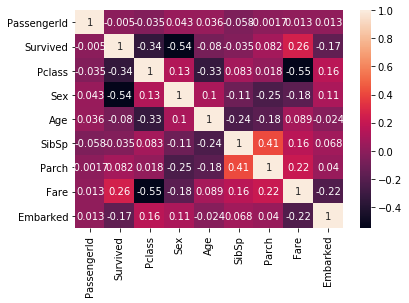

In [9]:
corrMatrix = train_data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
train_data['fam'] = train_data.SibSp + train_data.Parch
test_data['fam'] = test_data.SibSp + test_data.Parch

In [11]:
name = ''
for i in train_data.Name:
    name += i
    
li = re.findall('[a-zA-Z]+', name)
print('Most repeated: \n')
print(pd.Series(li).value_counts().head(10))

Most repeated: 

Mr         521
Miss       182
Mrs        129
William     49
Master      40
John        28
Henry       19
Charles     17
Thomas      17
George      16
dtype: int64


In [12]:
train_data['Master'] = train_data['Name'].str.contains('Master').astype(int)
train_data['Mr'] = train_data['Name'].str.contains('Mr').astype(int)
train_data['Miss'] = train_data['Name'].str.contains('Miss').astype(int)
train_data['Mrs'] = train_data['Name'].str.contains('Mrs').astype(int)

test_data['Master'] = test_data['Name'].str.contains('Master').astype(int)
test_data['Mr'] = test_data['Name'].str.contains('Mr').astype(int)
test_data['Miss'] = test_data['Name'].str.contains('Miss').astype(int)
test_data['Mrs'] = test_data['Name'].str.contains('Mrs').astype(int)

In [13]:
out=['Age','Fare']
df = train_data
for i in out:
    q25,q75=np.percentile(df[i],[25,75])
    iqr=q75-q25
    minimum=q25-(iqr*3)
    maximum=q75+(iqr*3)
#assigning nan to the outliers
    df[i].iloc[df[df[i]<minimum].index]=np.nan
    df[i].iloc[df[df[i]>maximum].index]=np.nan
#imputing nan values
df['Age']=df.Age.fillna(df.Age.mean())
df['Fare']=df.Fare.fillna(df.Fare.mean())

/home/kusumapani/.local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [14]:
def tree_cross_val(variables):
    
    X = train_data[variables]
    y = train_data['Survived']
    
    rkfold = RepeatedKFold(n_splits = 2, n_repeats = 10, random_state = 10)
    result = []
    for train_o, val_o in rkfold.split(X):
        X_train, X_val = X.iloc[train_o], X.iloc[val_o]
        y_train, y_val = y.iloc[train_o], y.iloc[val_o]
        
        decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
        decision_tree.fit(X_train, y_train)
        result.append(decision_tree.score(X_val, y_val))
        
    return np.mean(result)

In [15]:
variables_before = ['Age', 'Pclass', 'Fare', 'SibSp', 'Sex', 'Embarked']
print('Before the new features:', tree_cross_val(variables_before))

variables = ['Age', 'Sex', 'Pclass', 'Fare', 'fam', 'Master', 'Mr', 'Miss', 'Mrs']
print('After the new features:', tree_cross_val(variables))


Before the new features: 0.8070615206328414
After the new features: 0.8084088275306092


In [16]:
variables = ['Age', 'Sex', 'Pclass', 'Fare', 'fam', 'Master', 'Mr', 'Miss', 'Mrs']

X = train_data[variables]
y = train_data['Survived']

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(X,y)
pred = decision_tree.predict(test_data[variables])


final = pd.DataFrame({"PassengerId":test_data['PassengerId'], 'Survived':pred})

final.to_csv("/home/kusumapani/Desktop/empolis/Soultions_CSV/new_titanic_output.csv",index = False)